# Image Classification and Object Localization

In this notebook, we will construct a Convolutional Neural Network (CNN) from scratch aimed at two main tasks:
- Classifying the primary subject within an image.
- Localizing the subject by drawing bounding boxes around it.

To facilitate this, we'll creatively utilize the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset to generate a custom dataset tailored for this exercise:
- Each digit from the MNIST dataset will be placed on a larger black canvas, specifically a 75x75 pixel grid, at random positions.
- For each digit placed, we'll calculate the corresponding bounding boxes, defining the area that each digit occupies on the canvas.

Considering the bounding box prediction, this will be approached as a "regression" task. Unlike categorical tasks, regression will enable our model to predict continuous numeric values that define the boundaries of the bounding boxes. This approach enhances our model's capability to accurately pinpoint and size the region each digit occupies within the images.

## Imports

In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.12.0


# Helper Functions for Visualization

We will develop functions specifically designed to draw bounding boxes around the digits. These functions are crucial for visually confirming that our model correctly identifies and locates the digits within the larger canvas, effectively bridging the gap between image classification and object localization.

In [ ]:
im_width = 75
im_height = 75
use_normalized_coordinates = True

def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color=[],
                                       thickness=1,
                                       display_str_list=()):
  """Draws bounding boxes on image (numpy array).
  Args:
    image: a numpy array object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list_list: a list of strings for each bounding box.
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  image_pil = PIL.Image.fromarray(image)
  rgbimg = PIL.Image.new("RGBA", image_pil.size)
  rgbimg.paste(image_pil)
  draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness,
                               display_str_list)
  return np.array(rgbimg)


def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color=[],
                                 thickness=1,
                                 display_str_list=()):
  """Draws bounding boxes on image.
  Args:
    image: a PIL.Image object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: a list of strings for each bounding box.

  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                               boxes[i, 2], color[i], thickness, display_str_list[i])

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=1,
                               display_str=None,
                               use_normalized_coordinates=True):
  """Adds a bounding box to an image.
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: string to display in box
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = PIL.ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)



We will use the functions below to visualize both the data and the predictions made by our model. These tools are essential for inspecting the accuracy of our bounding boxes and understanding the model's performance in real-world scenarios, allowing us to make necessary adjustments and improvements.

In [ ]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):

  # Get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)

  # Eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      validation_bboxes = validation_bboxes.numpy()
      break
    for training_digits, (training_labels, training_bboxes) in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      training_bboxes = training_bboxes.numpy()
      break

  # One-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)

  return (training_digits, training_labels, training_bboxes,
          validation_digits, validation_labels, validation_bboxes)

# Create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (75*n, 75), color = (0,255))
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*75,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n, axis=1), axis=0), [n, 75*75])
  return font_digits, font_labels


# Display a row of digits with their predictions
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_labels = labels[indexes]

  n_iou = []
  if len(iou) > 0:
    n_iou = iou[indexes]

  if (len(pred_bboxes) > 0):
    n_pred_bboxes = pred_bboxes[indexes,:]

  if (len(bboxes) > 0):
    n_bboxes = bboxes[indexes,:]


  n_digits = n_digits * 255.0
  n_digits = n_digits.reshape(n, 75, 75)
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    bboxes_to_plot = []
    if (len(pred_bboxes) > i):
      bboxes_to_plot.append(n_pred_bboxes[i])

    if (len(bboxes) > i):
      bboxes_to_plot.append(n_bboxes[i])

    img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i], boxes=np.asarray(bboxes_to_plot), color=['red', 'green'], display_str_list=["true", "pred"])
    plt.xlabel(n_predictions[i])
    plt.xticks([])
    plt.yticks([])

    if n_predictions[i] != n_labels[i]:
      ax.xaxis.label.set_color('red')



    plt.imshow(img_to_draw)

    if len(iou) > i :
      color = "black"
      if (n_iou[i][0] < iou_threshold):
        color = "red"
      ax.text(0.2, -0.3, "iou: %s" %(n_iou[i][0]), color=color, transform=ax.transAxes)


# Display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Selecting Between Strategies

We will adapt our distribution strategy based on the hardware available to optimize computing resources and training efficiency:

- **TPU Strategy**: If a Tensor Processing Unit (TPU) is available, we will utilize the TPU Strategy, taking full advantage of its high computational power to speed up processing and training times.
  
- **Mirrored Strategy**: In cases where more than one GPU is available, the Mirrored Strategy will be employed. This approach synchronizes the data across the GPUs, ensuring efficient and parallel processing.

- **Default Strategy**: When only one GPU is available or if we are limited to just the CPU, the default strategy will be used. This strategy effectively handles the available resources, ensuring that the model training is still performed optimally despite the limited hardware capability.

These strategic decisions ensure that our model training is tailored to the specific hardware environment, maximizing performance and efficiency regardless of the setup.

In [ ]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.59.201.58:8470']
Number of accelerators:  8


### Parameters

The global batch size is determined by multiplying the batch size per replica, which is 64 in this instance, by the number of replicas in the distribution strategy. Here’s how it works:

- **Scaling the Batch Size**: If we're utilizing a TPU with 8 cores, the global batch size should be \( 64 \times 8 = 512 \). This scaling ensures that the workload is evenly distributed across all available cores.

- **Automatic Sharding**: The `tf.data.Dataset` API will automatically shard this global batch size across all the replicas, meaning that each core will handle an equal portion of the data during training.

- **Adjusting Learning Rate**: It's also recommended to increase the learning rate when scaling up the batch size. This is because a larger batch size generally provides a more accurate estimate of the gradient, but the updates are less frequent. Increasing the learning rate helps to compensate for these less frequent updates, aiding in maintaining or improving convergence speed.

By adhering to these best practices, we optimize training efficiency and effectiveness, leveraging the full computational power of the hardware configuration.


In [ ]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync

## Loading and Preprocessing the Dataset

To effectively manage our data and ensure it's appropriately prepared for training and validation, we'll define a series of helper functions:

1. **`read_image_tfds` Function**:
   - This function will handle the placement of each MNIST digit image onto a larger canvas. It randomly overlays the "digit" image onto a 75x75 black canvas, simulating variations in image positioning that the model might encounter in a real-world scenario.

2. **`get_training_dataset` Function**:
   - This function is responsible for loading the dataset and appropriately splitting it to extract the training set. It uses the initially loaded data to configure a training dataset that includes a majority of the data samples, ensuring sufficient examples for effective model training.

3. **`get_validation_dataset` Function**:
   - Similar to the training dataset function, this function loads the dataset and performs a split to isolate the validation set. The validation dataset is crucial for periodically evaluating the model's performance on data it has not been trained on, providing an estimate of how well the model generalizes to new data.

These functions are critical components of our data pipeline, ensuring that our dataset is not only loaded but also suitably pre-processed and partitioned into training and validation sets. By automating these tasks within helper functions, we streamline the process of preparing data for model training and validation, enhancing reproducibility and efficiency.

In [ ]:
# Transforms each image in dataset by pasting it on a 75x75 canvas at random locations.
def read_image_tfds(image, label):
    xmin = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    ymin = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    image = tf.reshape(image, (28,28,1,))
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    image = tf.cast(image, tf.float32)/255.0
    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)

    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    xmin = xmin / 75
    ymin = ymin / 75
    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])

# Loads and maps the training split of the dataset using the map function. Note that we try to load the gcs version since TPU can only work with datasets on Google Cloud Storage.
def get_training_dataset():

      with  strategy.scope():
        dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
        dataset = dataset.repeat() # Mandatory for Keras for now
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
        dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
      return dataset

# Loads and maps the validation split of the dataset using the map function. Note that we try to load the gcs version since TPU can only work with datasets on Google Cloud Storage.
def get_validation_dataset():
    dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

    #dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# Instantiate the datasets
with strategy.scope():
  training_dataset = get_training_dataset()
  validation_dataset = get_validation_dataset()

### Visualize Data

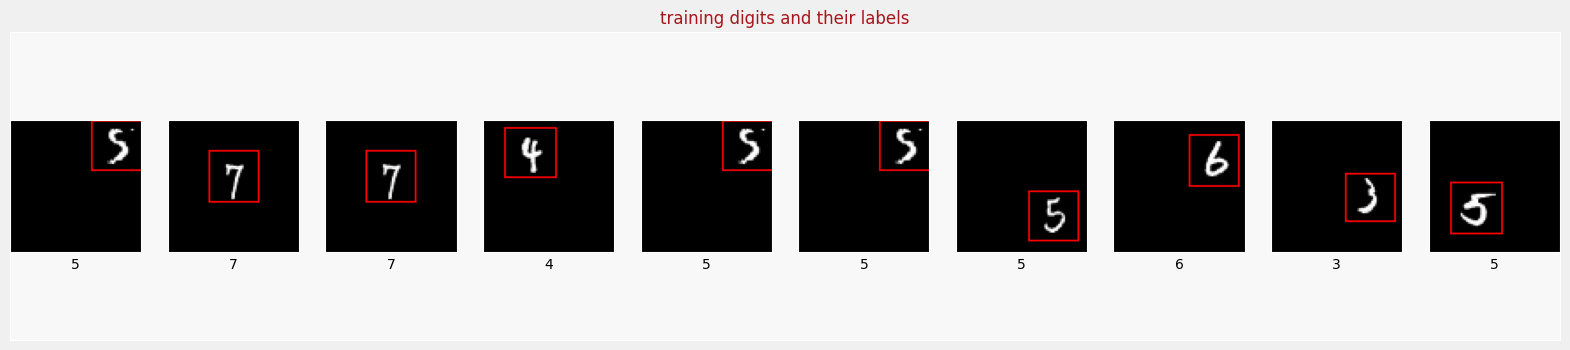

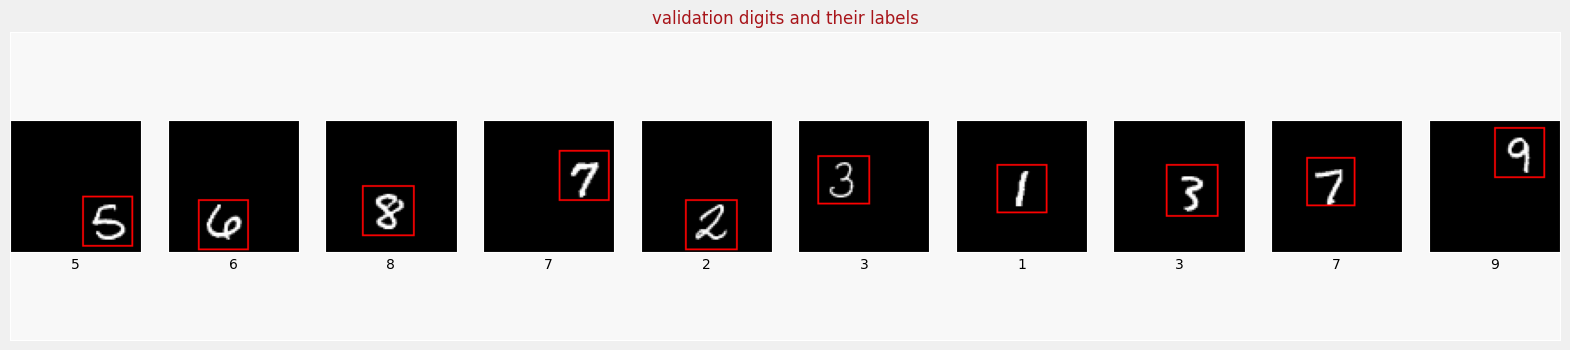

In [ ]:
(training_digits, training_labels, training_bboxes,
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, validation_dataset, 10)

display_digits_with_boxes(training_digits, training_labels, training_labels, np.array([]), training_bboxes, np.array([]), "training digits and their labels")
display_digits_with_boxes(validation_digits, validation_labels, validation_labels, np.array([]), validation_bboxes, np.array([]), "validation digits and their labels")

## Define the Network

In this section, we'll construct a custom Convolutional Neural Network (CNN) tailored for both classification and regression tasks within a single framework. Here's how we will structure our model:

1. **`feature_extractor`**:
   - These convolutional layers are designed to extract key features from the image. They serve as the initial phase of the model, processing the input image to generate a feature map that encapsulates essential visual information for further classification and regression.

2. **`classifier`**:
   - This component defines the output layer that classifies the images into one of the 10 digit categories (0 through 9). It takes the processed features from the `feature_extractor` and applies further layers specifically aimed at classification.

3. **`bounding_box_regression`**:
   - Parallel to the classification layers, this component predicts four numeric values representing the coordinates of the bounding box around the digit (xmin, ymin, xmax, ymax). This regression task complements the classification by providing spatial localization of the digit within the image.

4. **`final_model`**:
   - This model integrates the `feature_extractor`, `classifier`, and `bounding_box_regression` into a cohesive unit. It exemplifies a branching model where the network splits to produce dual outputs: a categorical label and a set of bounding box coordinates.
   - The use of the Functional API enables the definition of such a complex, branching architecture, showcasing the flexibility provided by this approach in handling multiple outputs.

5. **`define_and_compile_model`**:
   - In this final step, we will select the appropriate optimizer and metrics for our model. Common choices for the optimizer include Adam or SGD, depending on the specific requirements of the training regime. Metrics for the classifier might include accuracy, while for the bounding box regression, we might use Mean Squared Error (MSE) or another relevant metric.
   - After choosing the optimizer and metrics, the model is compiled, consolidating all the configurations and preparing it for training.

This structured approach not only allows us to build a sophisticated neural network capable of performing both classification and regression but also ensures that the model is versatile and adaptable to various tasks within image processing.

In [ ]:
# Feature extractor is the CNN that is made up of convolution and pooling layers.
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(75, 75, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    return x

# dense_layers adds a flatten and dense layer. This will follow the feature extraction layers
def dense_layers(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  return x



# Classifier defines the classification output. This has a set of fully connected layers and a softmax layer.
def classifier(inputs):

  classification_output = tf.keras.layers.Dense(10, activation='softmax', name = 'classification')(inputs)
  return classification_output


# Define the regression output for bounding box prediction. Note that we have four outputs corresponding to (xmin, ymin, xmax, ymax)
def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(units = '4', name = 'bounding_box')(inputs)
    return bounding_box_regression_output


def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)

    '''
    The model branches here.
    The dense layer's output gets fed into two branches:
    classification_output and bounding_box_output
    '''
    classification_output = classifier(dense_output)
    bounding_box_output = bounding_box_regression(dense_output)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_output, bounding_box_output])

    return model


def define_and_compile_model(inputs):
  model = final_model(inputs)

  model.compile(optimizer='adam',
              loss = {'classification' : 'categorical_crossentropy',
                      'bounding_box' : 'mse'
                     },
              metrics = {'classification' : 'accuracy',
                         'bounding_box' : 'mse'
                        })
  return model


with strategy.scope():
  inputs = tf.keras.layers.Input(shape=(75, 75, 1,))
  model = define_and_compile_model(inputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 73, 73, 16)   160         ['input_1[0][0]']                
                                                                                                  
 average_pooling2d (AveragePool  (None, 36, 36, 16)  0           ['conv2d[0][0]']                 
 ing2D)                                                                                           
                                                                                                  
 conv2d_1 (Conv2D)              (None, 34, 34, 32)   4640        ['average_pooling2d[0][0]']  

### Train and validate the model

Train the model.
- We can choose the number of epochs depending on the level of performance desired and the time available.
- Each epoch will take just a few seconds if we're using the TPU.

In [ ]:
EPOCHS = 10 # 45
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
validation_steps = 1

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", classification_accuracy)

Epoch 1/10
117/117 [==============================] - 12s 52ms/step - loss: 2.1708 - classification_loss: 2.1487 - bounding_box_loss: 0.0221 - classification_accuracy: 0.1996 - bounding_box_mse: 0.0221 - val_loss: 1.7003 - val_classification_loss: 1.6900 - val_bounding_box_loss: 0.0102 - val_classification_accuracy: 0.3744 - val_bounding_box_mse: 0.0102
Epoch 2/10
117/117 [==============================] - 3s 29ms/step - loss: 1.2614 - classification_loss: 1.2459 - bounding_box_loss: 0.0155 - classification_accuracy: 0.5733 - bounding_box_mse: 0.0155 - val_loss: 0.7511 - val_classification_loss: 0.7319 - val_bounding_box_loss: 0.0192 - val_classification_accuracy: 0.7693 - val_bounding_box_mse: 0.0192
Epoch 3/10
117/117 [==============================] - 3s 29ms/step - loss: 0.5863 - classification_loss: 0.5696 - bounding_box_loss: 0.0167 - classification_accuracy: 0.8301 - bounding_box_mse: 0.0167 - val_loss: 0.4297 - val_classification_loss: 0.4151 - val_bounding_box_loss: 0.0146 - v

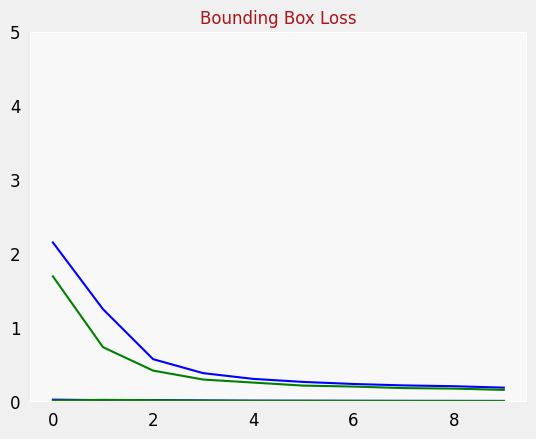

In [ ]:
plot_metrics("classification_loss", "Classification Loss")
plot_metrics("bounding_box_loss", "Bounding Box Loss")

## Intersection over union

Calculate the I-O-U metric to evaluate the model's performance.

In [ ]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

### Visualize predictions

Now, we will proceed to train our custom CNN model:

- **Setting the Epochs**: Decide on the number of epochs based on the desired level of performance and the time available. More epochs generally lead to better performance, as the model has more opportunities to learn from the data. However, this increases training time.

- **Training Process**: Utilize the previously compiled model to start training. If a TPU is available, each epoch will be significantly faster compared to training on CPUs or GPUs. This acceleration is due to the TPU's ability to process large batches of data simultaneously, making it highly efficient for training deep neural networks.

157/157 [==============================] - 5s 26ms/step
Number of predictions where iou > threshold(0.6): 5949
Number of predictions where iou < threshold(0.6): 4051


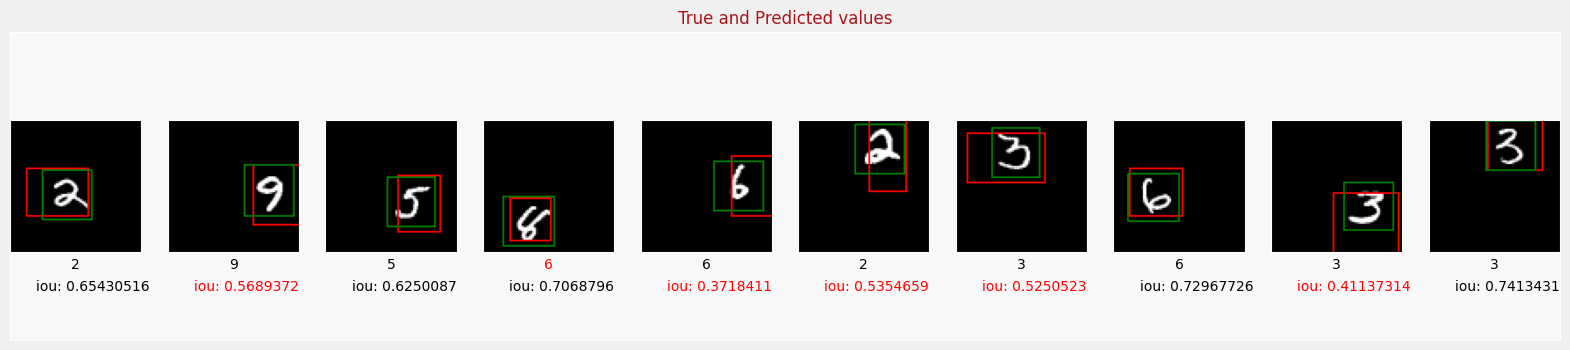

In [ ]:
predictions = model.predict(validation_digits, batch_size=64)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")